In [48]:
from datetime import datetime

from   hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
DATA = '../data'
sp = pd.read_csv(f'{DATA}/sp1950.csv')
nyse = pd.read_csv(f'{DATA}/nya1965.csv')
nas = pd.read_csv(f'{DATA}/nasdaq1965.csv')
wil = pd.read_csv(f'{DATA}/wilshire1990.csv')

In [3]:
sp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1,1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
2,1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
3,1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
4,1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000


In [4]:
x = sp['Adj Close'].to_numpy()
np.append([np.nan], x[1:] / x[:-1])

array([       nan, 1.01140459, 1.00474777, ..., 1.00291616, 1.01409161,
       0.96631194])

In [5]:
def get_daily_changes(series):
    x = series.to_numpy()
    return np.append([1], x[1:] / x[:-1])

In [6]:
def prep_df(df, name):
    df.index = pd.to_datetime(df.Date)
    df[f'{name}_daily'] = get_daily_changes(df['Adj Close'])
    df.rename(columns={'Adj Close': name}, inplace=True)
    return df[[name, f'{name}_daily']]

In [7]:
[sp, nyse, nas, wil] = [prep_df(df, name) for df, name in zip([sp, nyse, nas, wil], ['sp', 'nyse', 'nas', 'wil'])]
sp.head()

,sp,sp_daily
Date,,
1950-01-03,16.66,1.000000
1950-01-04,16.85,1.011405
1950-01-05,16.93,1.004748
1950-01-06,16.98,1.002953
1950-01-09,17.08,1.005889


In [8]:
nyse.head()

,nyse,nyse_daily
Date,,
1965-12-31,528.690002,1.000000
1966-01-03,527.210022,0.997201
1966-01-04,527.840027,1.001195
1966-01-05,531.119995,1.006214
1966-01-06,532.070007,1.001789


In [9]:
nas.head()

,nas,nas_daily
Date,,
1971-02-05,100.000000,1.000000
1971-02-08,100.839996,1.008400
1971-02-09,100.760002,0.999207
1971-02-10,100.690002,0.999305
1971-02-11,101.449997,1.007548


In [10]:
def find_best_mod(daily, n_states=[6, 7, 8], max_iter=1000):
    daily = np.reshape(daily.values, [-1, 1])
    best_logprob = -np.inf
    best_mod = None
    for states in n_states:
        mod = GaussianHMM(
            n_components=states, n_iter=max_iter
        ).fit(daily)
        logprob = mod.score(daily)
        if logprob > best_logprob:
            print(f'New best - States: {states}')
            best_logprob = logprob
            best_mod = mod
    return best_mod

In [11]:
def get_preds(daily, mod):
    daily = np.reshape(daily.values, [-1, 1])
    states = mod.predict(daily)
    means = np.squeeze(mod.means_)
    sds = np.squeeze(np.sqrt(mod.covars_))
    preds = np.array([means[state] for state in states])
    ses = np.array([1.96 * sds[state] for state in states])
    return preds, ses, means, states[-1]

In [18]:
def plot_mod(df, preds, ses, name):
    daily = f'{name}_daily'
    plt.plot(df[daily], label='daily')
    plt.plot(df.index, preds, label='preds')
    plt.legend()

    plt.figure()
    plt.plot(df[daily], label='daily')
    plt.axhline(y=1, color='k')
    plt.plot(
        df.index, preds, label='preds', color='orange', linewidth=3)
    plt.plot(df.index, preds + ses, color='orange', linestyle='-.')
    plt.plot(df.index, preds - ses, color='orange', linestyle='-.')
    plt.ylim([0.95, 1.05]);
    plt.xlim([df.index[-500], df.index[-1]])

    plt.figure()
    plt.plot(df[name])
    plt.xlim([df.index[-500], df.index[-1]])
    sub = df.iloc[-500:, :]
    plt.ylim(
        0.95 * sub[name].min(), 1.05 * sub[name].max());

In [19]:
def get_expected_val(mod, current_state, means):
    return np.dot(mod.transmat_[current_state, :], means)

## S&P

New best - States: 5
New best - States: 6
1.0000155994596842


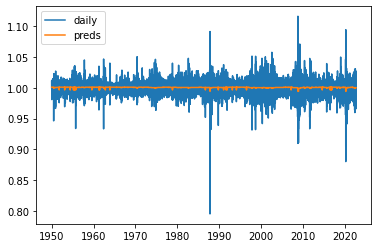

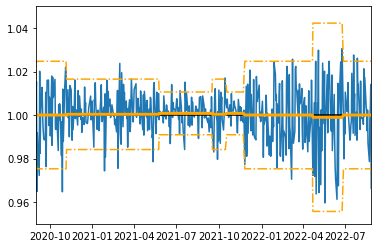

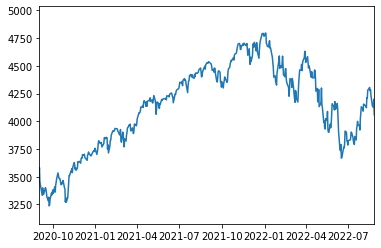

In [20]:
sp_mod = find_best_mod(sp.sp_daily, n_states=[5, 6, 7])
sp_preds, sp_ses, sp_means, sp_current = get_preds(sp.sp_daily, sp_mod)
plot_mod(sp, sp_preds, sp_ses, 'sp')
sp_exp = get_expected_val(sp_mod, sp_current, sp_means)
print(sp_exp)

## NYSE

New best - States: 5
New best - States: 6
1.0003999187632877


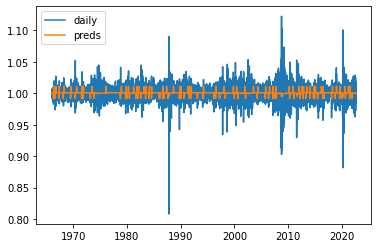

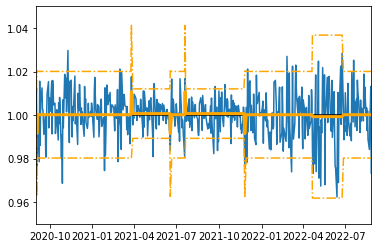

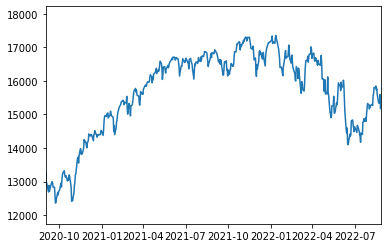

In [21]:
nyse_mod = find_best_mod(nyse.nyse_daily, n_states=[5, 6, 7, 8])
nyse_preds, nyse_ses, nyse_means, nyse_current = get_preds(
    nyse.nyse_daily, nyse_mod)
plot_mod(nyse, nyse_preds, nyse_ses, 'nyse')
nyse_exp = get_expected_val(nyse_mod, nyse_current, nyse_means)
print(nyse_exp)

## Nasdaq

New best - States: 6
New best - States: 7
1.00050781181395


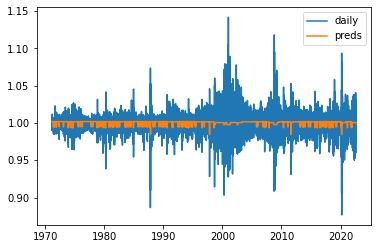

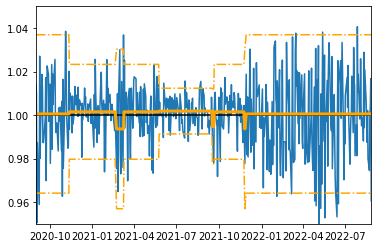

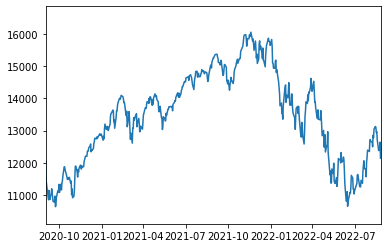

In [23]:
nas_mod = find_best_mod(nas.nas_daily, n_states=[6, 7, 8])
nas_preds, nas_ses, nas_means, nas_current = get_preds(
    nas.nas_daily, nas_mod)
plot_mod(nas, nas_preds, nas_ses, 'nas')
nas_exp = get_expected_val(nas_mod, nas_current, nas_means)
print(nas_exp)

## Wilshire

New best - States: 5
New best - States: 7
1.0003154346412761


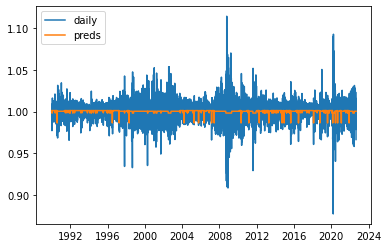

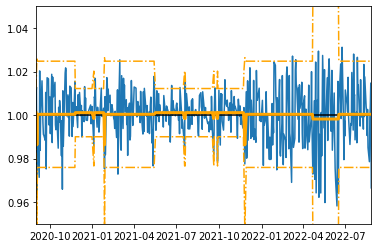

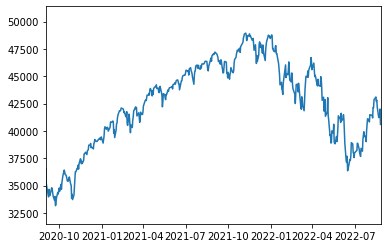

In [25]:
wil_mod = find_best_mod(wil.wil_daily, n_states=[5, 6, 7, 8])
wil_preds, wil_ses, wil_means, wil_current = get_preds(
    wil.wil_daily, wil_mod)
plot_mod(wil, wil_preds, wil_ses, 'wil')
wil_exp = get_expected_val(wil_mod, wil_current, wil_means)
print(wil_exp)

In [26]:
exp = (sp_exp + nyse_exp + nas_exp + wil_exp) / 4
exp

1.0003096911695495

In [31]:
for df, name, exp in zip(
    [sp, nyse, nas, wil], ['sp', 'nyse', 'nas', 'wil'], [sp_preds, nyse_preds, nas_preds, wil_preds]):
    df[f'{name}_exp'] = exp

In [32]:
df = pd.concat([sp, nyse, nas, wil], axis=1)
df.tail()

,sp,sp_daily,sp_exp,nyse,nyse_daily,nyse_exp,nas,nas_daily,nas_exp,wil,wil_daily,wil_exp
Date,,,,,,,,,,,,
2022-08-22,4137.990234,0.978600,1.000018,15341.849609,0.984189,1.000162,12381.570312,0.974526,1.000523,41273.171875,0.978564,1.000353
2022-08-23,4128.729980,0.997762,1.000018,15338.150391,0.999759,1.000162,12381.299805,0.999978,1.000523,41224.390625,0.998818,1.000353
2022-08-24,4140.770020,1.002916,1.000018,15392.059570,1.003515,1.000162,12431.530273,1.004057,1.000523,41395.699219,1.004156,1.000353
2022-08-25,4199.120117,1.014092,1.000018,15595.240234,1.013200,1.000162,12639.269531,1.016711,1.000523,42005.289062,1.014726,1.000353
2022-08-26,4057.659912,0.966312,1.000018,15178.208008,0.973259,1.000162,12141.709961,0.960634,1.000523,40598.789062,0.966516,1.000353


In [41]:
df['mean_exp'] = df[['sp_exp', 'nyse_exp', 'nas_exp', 'wil_exp']].mean(axis=1)

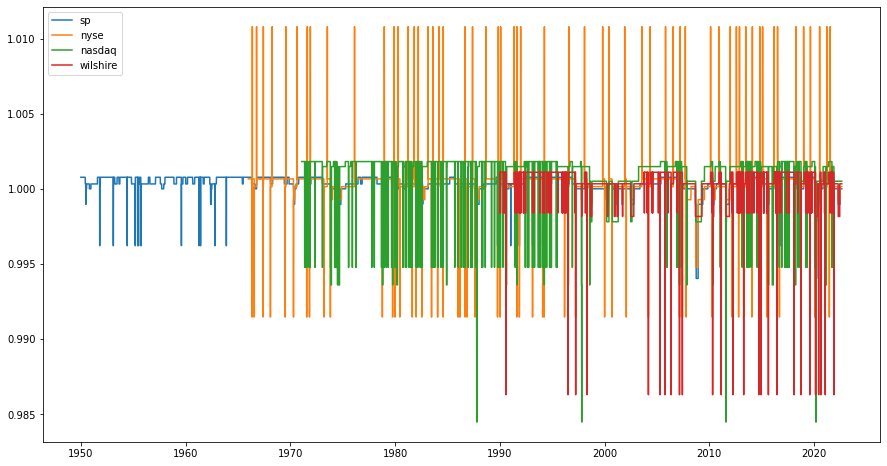

In [45]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, label='sp')
plt.plot(df.nyse_exp, label='nyse')
plt.plot(df.nas_exp, label='nasdaq')
plt.plot(df.wil_exp, label='wilshire')

plt.legend();

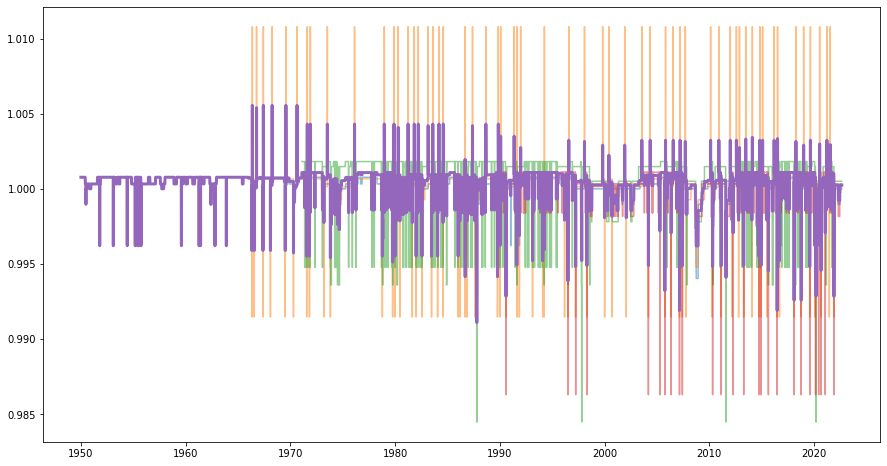

In [47]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3);

(14610.0, 19230.881725435578)

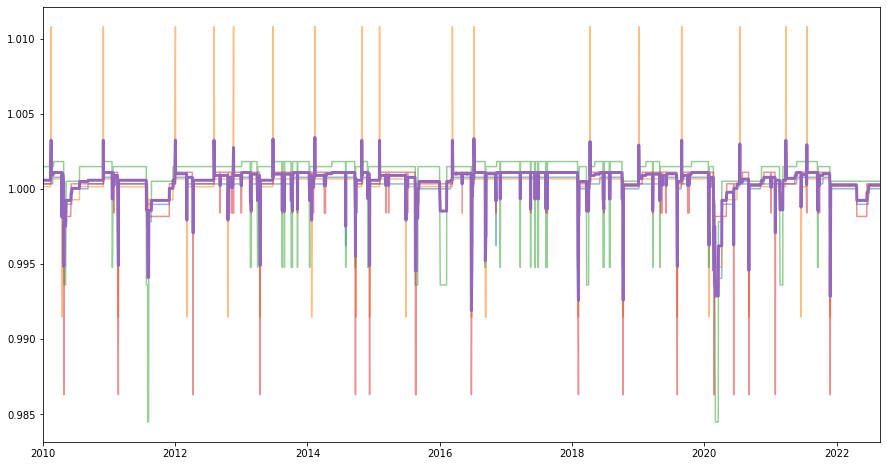

In [49]:
TODAY = datetime.now()
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.xlim(pd.to_datetime('2010-01-01'), TODAY);

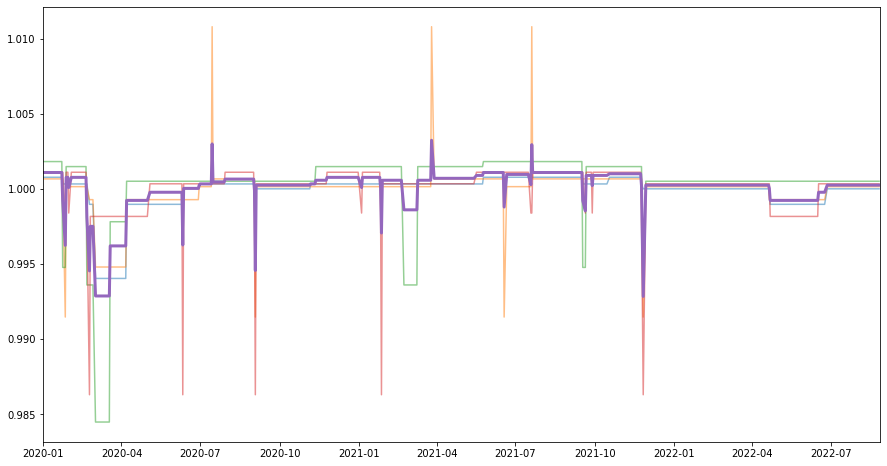

In [51]:
TODAY = datetime.now()
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.xlim(pd.to_datetime('2020-01-01'), TODAY);

In [68]:
N_STATES = 4
df['state'] = pd.qcut(df.mean_exp, N_STATES, retbins=False, labels=range(N_STATES))

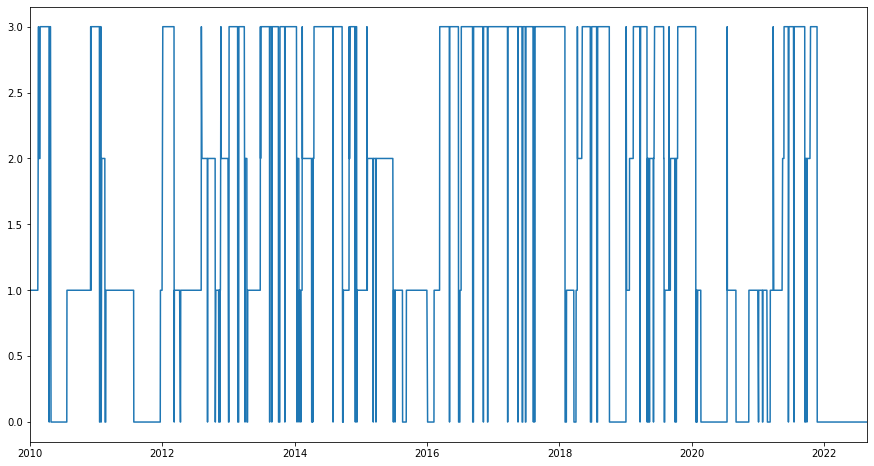

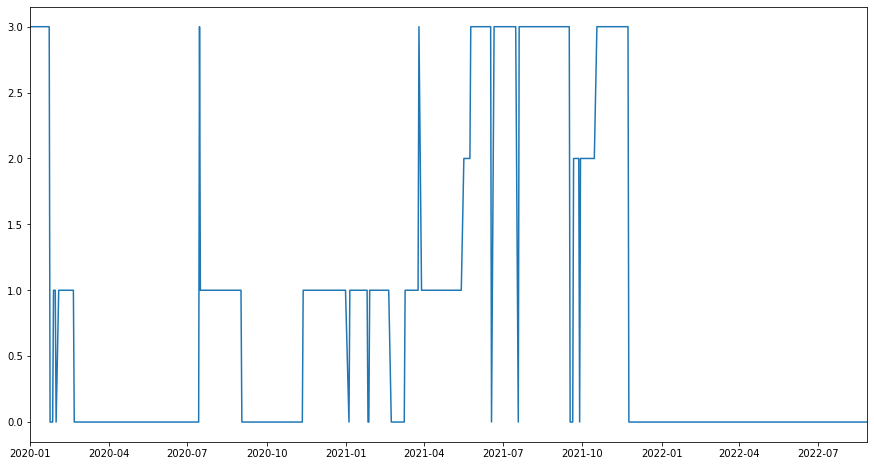

In [69]:
plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2010-01-01'), TODAY);

plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2020-01-01'), TODAY);

In [72]:
df.to_csv(f'{DATA}/hmm_exp_returns.csv')